# Natural Language Processing and Clustering Optimization for Music Album Recommendation

## Authors: Nurzhan Kanatzhanov & Pranav Jain
## Final Project for CSE 543T
## Professor Yixin Chen
## Date: December 18, 2021

In [55]:
# Pre-processing helper functions for tokenization, text cleanup (punctuation stripping, lowercase), and file reading

import math, re
import glob, os
import pandas as pd
from collections import Counter

def tokenize(s):
    """
    Input: 
        string s
    Output: 
        list of strings
    """
    return s.split()

def preprocess(s, lowercase=True, strip_punctuation=True):
    """
    Input:
        string s
        boolean lowercase
        boolean strip_punctuation
    Return:
        list of strings
    """
    punctuation = '.,?<>:;"\'!%'
    if isinstance(s, str):
        s = tokenize(s)
    if lowercase:
        s = [t.lower() for t in s]
    if strip_punctuation:
        s = [t.strip(punctuation) for t in s]
        
    return s

def token_frequency(tokens=None, tf={}, relative=False):
    """
    Input:
        tokens = list of strings or None
        tf = dict or None
        relative = boolean
    Return:
        dictionary of token frequencies
    """
    for t in tokens:
        if t in tf:
            tf[t]+=1
        else:
            tf[t]=1
    if relative:
        total = sum([c for t, c in tf.items()])
        tf = {t:tf[t]/total for t in tf}
    return tf

def get_texts(filenames, stop_words):
    for fn in filenames:
        text = open(fn, 'r').read()
        text = [t for t in preprocess(text) if t not in stop_words]
        yield(text)

#### The path provided below is local. The zip with all of the 71 text files will be provided along with this code with our submission. Please update the path below to your personal local machine path when trying to run this file.


#### using ```glob``` module to retrieve files/pathnames of all .txt files (credit to [AZLyrics](https://azlyrics.com) for the lyrics of the artists)

In [56]:
path = '/Users/nurzhan/Desktop/all_albums_together/*.txt'
filenames = glob.glob(path)
len(filenames)

71

#### Quick file check

In [58]:
text_lengths = []
for file in filenames:
    text = open(file, 'r').read()
    text = preprocess(text)
    text_lengths.append(len(text))
    
from statistics import median, pstdev
print("Mean file word length: ", sum(text_lengths) / len(filenames))
print("Min file word length: ", min(text_lengths))
print("Max file word length: ", max(text_lengths))
print("Standard deviation of file word length: ", pstdev(text_lengths))

Mean file word length:  5036.957746478874
Min file word length:  1341
Max file word length:  14691
Standard deviation of file word length:  3221.6528276455565


### Main experiment with 100 iterations. 

#### *Note: you might have to download the [gensim](https://pypi.org/project/gensim/) python library and the [nltk.corpus](https://stackoverflow.com/questions/22211525/how-do-i-download-nltk-data). Click on the links for instructions.

In [63]:
# importing all needed functions
from sklearn.metrics import silhouette_score
from gensim import corpora, models, similarities
from sklearn.cluster import KMeans, OPTICS, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import time

# start time calculation
start_time = time.time()

##### UNCOMMENT THE FOLLOWING TWO LINES TO DOWNLOAD STOPWORDS:
# import nltk
# nltk.download('stopwords')

# getting the list of common stopwords to filter out during pre-processing
from nltk.corpus import stopwords
nltk_stop_words = set(stopwords.words('english'))

results = {}

NUM_ITERATIONS = 100

# repeat experiment 100 times
for bruh in range(NUM_ITERATIONS):
    for NUM_TOPICS in range(3,11):
        # TOPIC MODELING - LDA MODEL
        dictionary = corpora.Dictionary(get_texts(filenames, nltk_stop_words))
        corpus = [dictionary.doc2bow(text) for text in get_texts(filenames, nltk_stop_words)]
        lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS)

        corpus_lda = lda[corpus]

        # GETTING TEXT LABELS from filenames
        labels = [os.path.split(fn)[1][:-4].replace('_', ' ').title() for fn in filenames]

        # making vector based on number of topics (NUM_TOPICS)
        topics = list(range(NUM_TOPICS))
        vectors = [{index:ratio for index, ratio in v} for v in corpus_lda]
        
        # final dataframe from LDA
        vectors_df = pd.DataFrame(vectors, index=labels, columns=topics).fillna(0)
        
        # Principal component analysis (PCA) - reducing the dimensionality of the LDA dataframe
        pca = PCA(n_components=2)
        transformed = pca.fit_transform(vectors_df)

        x = transformed[:,0]
        y = transformed[:,1]
        
        # making new transformed dataframe
        transformed_df = pd.DataFrame({'x':x,'y':y}, index=labels)

        # K-MEANS clustering with preset number of clusters (5)
        N_CLUSTERS = 5
        kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(transformed_df)
        kmeans_labels = kmeans.labels_

        # SILHOUETTE SCORE - calculating the "goodness of fit" for clusters (their consisteny and significance)
        score = silhouette_score(transformed_df, kmeans_labels, metric = 'euclidean')
        
        # saving all scores for each number of topics
        if NUM_TOPICS in results:
            results[NUM_TOPICS] += score
        else:
            results[NUM_TOPICS] = score

print("--- %s seconds ---" % (time.time() - start_time))

# averaging out results over 100 iterations
for key in results:
    results[key] /= NUM_ITERATIONS

best_NUM_TOPICS = max(results, key=results.get)
print("Best number of topics to use: ", best_NUM_TOPICS)
results

--- 7.275903940200806 seconds ---
Best number of topics to use:  4


{3: 0.006053938053523318,
 4: 0.006958740524482388,
 5: 0.006522610063170954,
 6: 0.005836695974962387,
 7: 0.005845928596601135,
 8: 0.006058192469814918,
 9: 0.006597767883436667,
 10: 0.00603780021287066}

### After performing the main experiment above, we wanted to visualize clusters for better representation. Convex hull idea to contour clusters taken from [here](https://towardsdatascience.com/clustering-using-convex-hulls-fddafeaa963c). 

Silhouette coeff.:  0.640541605571963


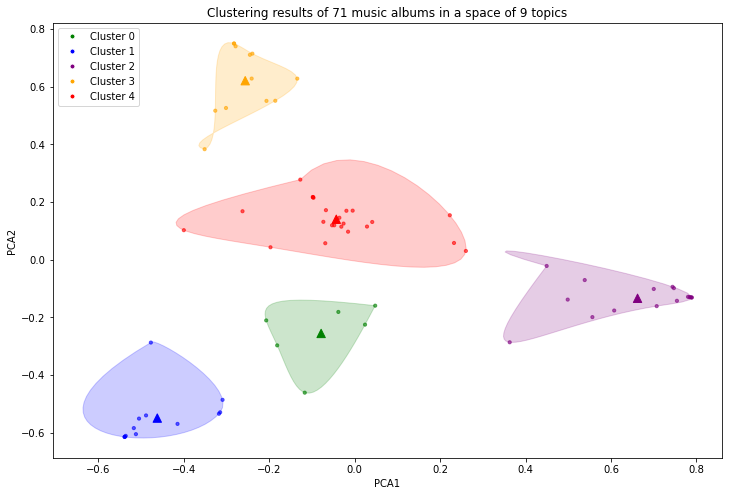

In [52]:
# graphing clustering analysis visually with best number of topics for LDA

NUM_TOPICS = best_NUM_TOPICS

dictionary = corpora.Dictionary(get_texts(filenames, nltk_stop_words))
corpus = [dictionary.doc2bow(text) for text in get_texts(filenames, nltk_stop_words)]
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS)

corpus_lda = lda[corpus]

# GETTING TEXT LABELS
labels = [os.path.split(fn)[1][:-4].replace('_', ' ').title() for fn in filenames]

# making vector based on number of topics (NUM_TOPICS)
topics = list(range(NUM_TOPICS))
vectors = [{index:ratio for index, ratio in v} for v in corpus_lda]

vectors_df = pd.DataFrame(vectors, index=labels, columns=topics).fillna(0)

pca = PCA(n_components=2)
transformed = pca.fit_transform(vectors_df)

x = transformed[:,0]
y = transformed[:,1]

# making new transformed dataframe
transformed_df = pd.DataFrame({'x':x,'y':y}, index=labels)

from scipy.spatial import ConvexHull
from scipy import interpolate
import numpy as np

#K-MEANS
N_CLUSTERS=5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(transformed_df)
kmeans_labels = kmeans.labels_

print("Silhouette coeff.: ", silhouette_score(transformed_df, kmeans_labels, metric = 'euclidean'))

transformed_df['cluster'] = kmeans.fit_predict(transformed_df)

centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

transformed_df['cen_x'] = transformed_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3],4:cen_x[4]})
transformed_df['cen_y'] = transformed_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2],3:cen_y[3],4:cen_y[4]})

colors = ['green', 'blue', 'purple', 'orange','red']
transformed_df['c'] = transformed_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3],4:colors[4]})

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1, figsize=(12,8))

plt.scatter(transformed_df.x, transformed_df.y, c=transformed_df.c, alpha = 0.6, s=10)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]

plt.legend(handles=legend_elements, loc='upper left')

for i in transformed_df.cluster.unique():
    # get the convex hull
    points = transformed_df[transformed_df.cluster == i][['x', 'y']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("Clustering results of 71 music albums in a space of {} topics".format(NUM_TOPICS))

plt.show()

### Displaying the contents of each cluster 

In [53]:
labelDict = {}
for cluster_label, l in zip(kmeans_labels, labels):
    curr = labelDict.get(cluster_label, [])
    curr.append(l)
    labelDict[cluster_label] = curr

dict(sorted(labelDict.items()))

{0: ['Drake Scorpion',
  'Eminem The Eminem Show',
  'Britney Spears Oops I Did It Again',
  'Beatles White Album',
  'Drake More Life',
  'Sam Smith The Thrill Of It All'],
 1: ['The Strokes Room On Fire',
  'Xxxtentacion Question Mark',
  'Tyler The Creator Igor',
  'Turnstile Glow On',
  'Limp Bizkit Significant Other',
  'Acdc Blow Up Your Video',
  'Imagine Dragons Night Visions',
  'Ozzy Osbourne Speak Of The Devil',
  'Prince Purple Rain',
  'Bastille Bad Blood',
  'Kesha Warrior',
  'Rina Sawayama Sawayama',
  'Billie Eilish Happier Than Ever'],
 2: ['Elton John Blue Moves',
  'Michael Buble Christmas',
  'Amy Winehouse Back To Black',
  'Acdc Back In Black',
  'Acdc Dirty Deeds Done Dirt Cheap',
  'Ed Sheeran +',
  'The Smiths The Smiths',
  'Linkin Park Hybrid Theory',
  'The Eagles Hotel California',
  'Adele 25',
  'Beatles With The Beatles',
  'Charli Xcx Charli',
  'Jaden Smith Syre',
  'Neutral Milk Aeroplane Over The Sea',
  'Anderson Paak Oxnard',
  'Chris Stapleton St

### using gensim's sparse matrix similarity function to find most similar texts

In [54]:
similarity_index = similarities.SparseMatrixSimilarity(corpus_lda, num_features=NUM_TOPICS)

print('Most similar texts:\n')
for i, label in enumerate(labels):
    sim = similarity_index[corpus_lda[i]]
    sim_labels = sorted(zip(sim, labels), reverse=True)
    sim_print = [l for s, l in sim_labels][1:4]
    sim_print = ', '.join(sim_print)
    print('{}: {}\n'.format(label, sim_print))

Most similar texts:

Elton John Blue Moves: Neutral Milk Aeroplane Over The Sea, Michael Buble Christmas, Ed Sheeran +

Michael Buble Christmas: Michael Buble Christmas, Ed Sheeran +, Anderson Paak Oxnard

Elliot Smith Figure 8: Taylor Swift Folklore, Beatles Sgt Pepper, Kanye Graduation

Amy Winehouse Back To Black: The Eagles Hotel California, Linkin Park Hybrid Theory, Elton John Blue Moves

Baby Keem Die For My Bitch: Danny Brown Atrocity Exhibition, Eminem Slim Shady Lp, Nirvana In Utero

The Strokes Room On Fire: Turnstile Glow On, Rina Sawayama Sawayama, Ozzy Osbourne Speak Of The Devil

Xxxtentacion Question Mark: Turnstile Glow On, Rina Sawayama Sawayama, Ozzy Osbourne Speak Of The Devil

Tyler The Creator Igor: Turnstile Glow On, Rina Sawayama Sawayama, Ozzy Osbourne Speak Of The Devil

Taylor Swift Folklore: Elliot Smith Figure 8, Beatles Sgt Pepper, Kanye Graduation

Behemoth The Satanist: Tame Impala Currents, Elliot Smith Figure 8, Beatles Sgt Pepper

Judas Priest Defende